# Preprocess h5ad file for CellOracle
**Authorship:** Adam Klie (last updated: 08/01/2023)<br>
***
**Description:** This notebook takes in an h5ad file with raw counts in it and will preprocess it for CellOracle.

To preprocess the scRNA-seq data, we will do the following:

1. Variable gene selection and normalization.
2. Log transformation. Like many preprocessing workflows, we need to log transform the data. However, CellOracle also needs the raw gene expression values, which we will store in an anndata layer.
3. Cell clustering.
4. Dimensional reduction. We need to prepare the 2D embedding data. Please make sure that the 2D embedding properly represents the cell identities and processes of interest. Also, please consider the resolution and continuity of the data. CellOracle’s simulation results are only informative when the embedding is consistent with the questions being investigated.
***

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = [6, 4.5]

# Load AnnData object

In [ ]:
# Link to the h5ad file
h5ad_file = "/cellar/users/aklie/data/igvf/topic_grn_links/h5ad/igvf_b01_LeftCortex/0.05/Microglia.h5ad"

In [ ]:
# Load using scanpy
adata = sc.read_h5ad(h5ad_file)
adata

/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 3251 × 2000
    obs: 'kallisto_cellID', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'sublibrary', 'Experiment', 'Kit', 'Tissue', 'Mouse_Tissue_ID', 'Genotype', 'Sex', 'Replicate', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Tissue_weight_mg', 'nCount_RNA', 'nFeature_RNA', 'doublet_scores', 'percent.mt', 'percent.ribo', 'G2M.Score', 'seurat_clusters', 'celltypes', 'subtypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# QC and preprocessing

In [5]:
# Only consider genes with more than 1 count
sc.pp.filter_genes(adata, min_counts=1)

/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
# Create a new column in the adata.obs dataframe that contains the log of the total counts for each cell, for plotting
adata.obs['log_counts'] = np.log(adata.obs['total_counts'])

In [7]:
# Keep raw cont data before log transformation
adata.raw = adata
adata.layers["raw_counts"] = adata.raw.X.copy()

In [8]:
# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [12]:
# Select top 2000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=2000, log=False)

# Subset the genes
adata = adata[:, filter_result.gene_subset]

# Renormalize after filtering
sc.pp.normalize_per_cell(adata)

/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell
/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [14]:
# keep raw cont data before log transformation
adata.raw = adata
adata.layers["raw_count"] = adata.raw.X.copy()

In [15]:
# Log transformation and scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [9]:
# Add log normalized counts to adata layers
adata.layers["log_normalized_counts"] = adata.X
adata.X[:10, :10].todense()

matrix([[0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 4.0972004, 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 4.4768424],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 5.105548 , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.

In [ ]:
# Put a mask in for variable genes
sc.pp.highly_variable_genes(adata)

In [23]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')

/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


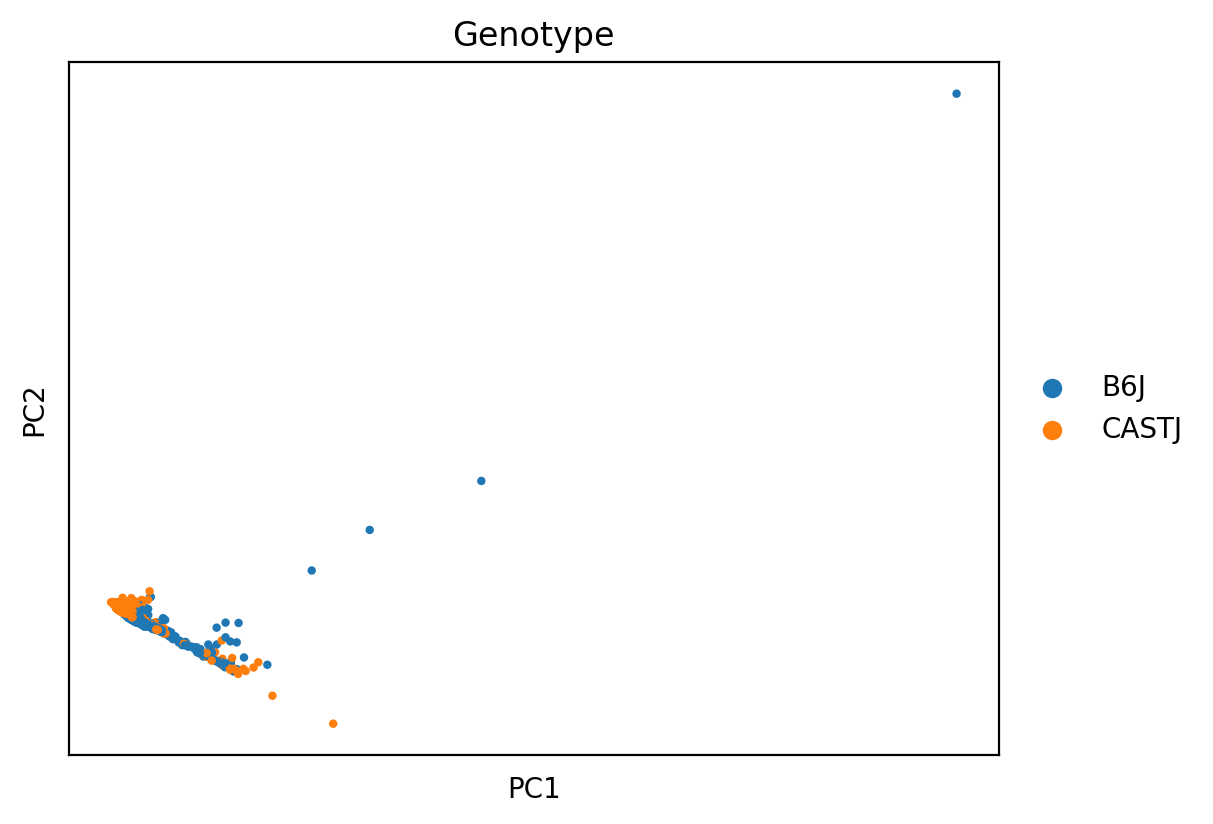

In [28]:
sc.pl.pca(adata, color="Genotype")

In [ ]:
# Diffusion map
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.diffmap(adata)

# Calculate neihbors again based on diffusionmap
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

In [24]:
# Cell clustering
sc.tl.louvain(adata, resolution=0.8)

In [25]:
# PAGA graph construction
sc.tl.paga(adata, groups='louvain')

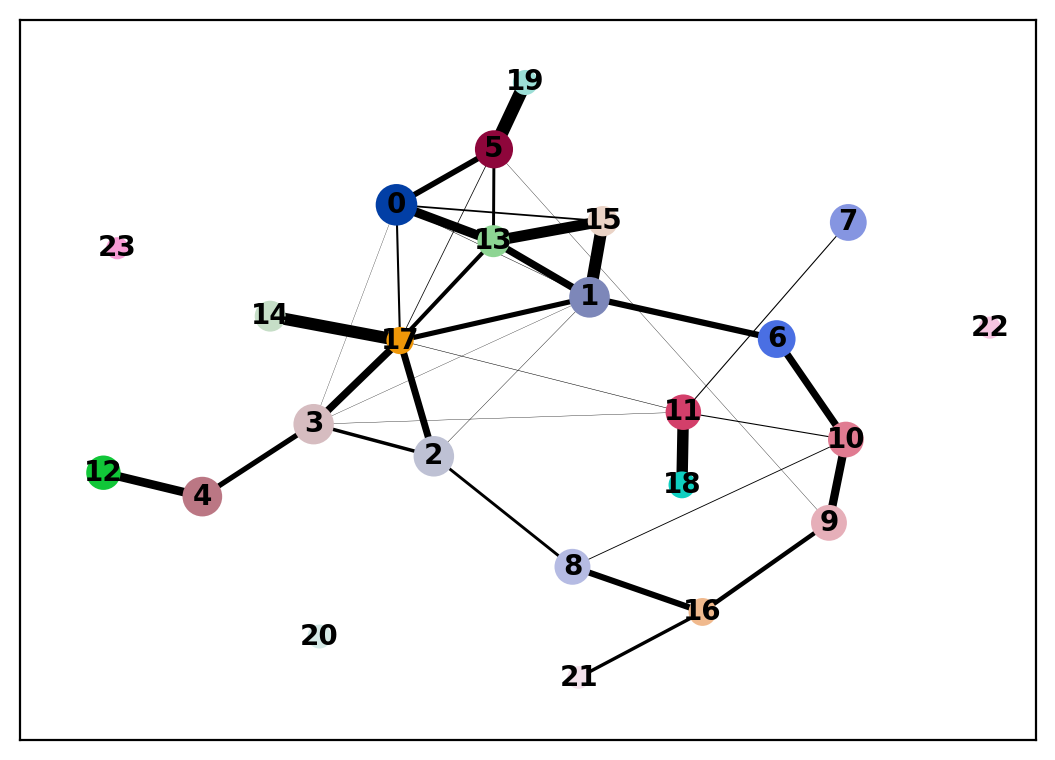

In [30]:
# Vis
sc.pl.paga(adata)

In [31]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)

/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


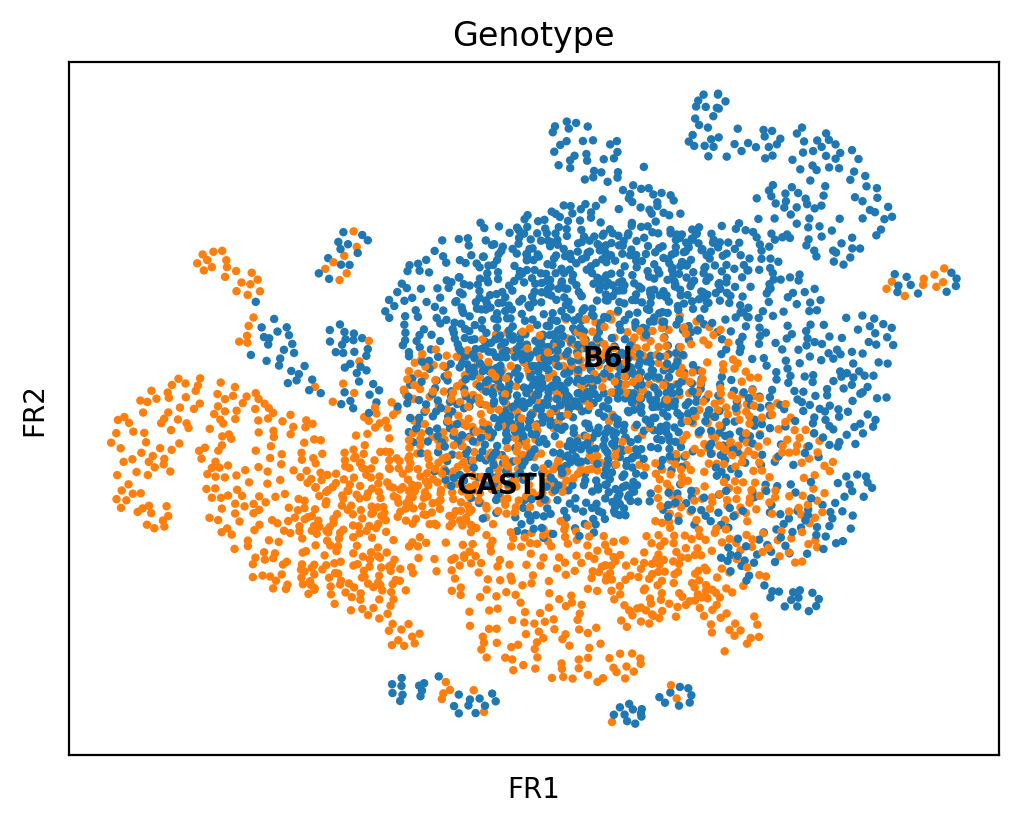

In [32]:
sc.pl.draw_graph(adata, color='Genotype', legend_loc='on data')

In [34]:
adata.write_h5ad("/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/celloracle/results/igvf_b01_LeftCortex/Microglia_scRNA_prep.h5ad")

# DONE!


---

# Scratch